<a href="https://colab.research.google.com/github/karthiknadar1204/generative_deep_learning/blob/main/dreambooth_fine_tuning_demo_WITHOUT_INSTANCE_PROMPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Enable GPU in the notebook (Already done in Runtime settings)
# Install PyTorch with CUDA support
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

# Check NVIDIA and CUDA installation
!nvidia-smi
!nvcc --version

# Verify if PyTorch can access the GPU
import torch

if torch.cuda.is_available():
    print(f"CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none

In [2]:
zip_path = "/content/ThankYou.zip"

extract_path = "/content/unzipped_ThankYou_files"

!mkdir -p {extract_path}

!unzip {zip_path} -d {extract_path}

print("Files unzipped successfully!")


Archive:  /content/ThankYou.zip
   creating: /content/unzipped_ThankYou_files/ThankYou/
  inflating: /content/unzipped_ThankYou_files/__MACOSX/._ThankYou  
  inflating: /content/unzipped_ThankYou_files/ThankYou/Thank_you_3.jpeg  
  inflating: /content/unzipped_ThankYou_files/__MACOSX/ThankYou/._Thank_you_3.jpeg  
  inflating: /content/unzipped_ThankYou_files/ThankYou/Thank_you_4.jpeg  
  inflating: /content/unzipped_ThankYou_files/__MACOSX/ThankYou/._Thank_you_4.jpeg  
  inflating: /content/unzipped_ThankYou_files/ThankYou/Thank_you_image_2.jpeg  
  inflating: /content/unzipped_ThankYou_files/__MACOSX/ThankYou/._Thank_you_image_2.jpeg  
  inflating: /content/unzipped_ThankYou_files/ThankYou/Screenshot 2024-06-05 at 9.17.47 PM.png  
  inflating: /content/unzipped_ThankYou_files/__MACOSX/ThankYou/._Screenshot 2024-06-05 at 9.17.47 PM.png  
  inflating: /content/unzipped_ThankYou_files/ThankYou/Thank_you_1.jpeg  
  inflating: /content/unzipped_ThankYou_files/__MACOSX/ThankYou/._Thank_you_

In [3]:
#@title GPU Check
!nvidia-smi

Wed Jun  5 16:53:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
%%capture
!pip install -qq "ipywidgets>=7,<8"
!git clone https://github.com/huggingface/diffusers
%cd /content/diffusers
!pip install .

In [5]:
%%capture
%cd /content/diffusers/examples/dreambooth
!pip install -r requirements.txt
!pip install wandb
!pip install bitsandbytes
!pip install transformers gradio ftfy accelerate
import gradio

In [6]:
!pip install xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 MB 6.3 MB/s eta 0:00:00


In [7]:
#@title Utils for Dataset Preprocessing
#@markdown * Resize and crop function
#@markdown * Function to show images in a one row

from PIL import Image
import os
import IPython.display as display
import matplotlib.pyplot as plt

def resize_and_crop_images(folder_path, target_size=512):
    """
    Resize the images in a folder to have a smaller edge of the specified target size and display them.

    Parameters:
    - folder_path (str): Path to the folder containing the images.
    - target_size (int): Desired size for the smaller edge (default is 512).
    """
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Check if the file is an image
        if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            # Open the image
            image = Image.open(file_path)

            # Get the original width and height
            width, height = image.size

            # Calculate the new size while maintaining the aspect ratio
            if width <= height:
                new_width = target_size
                new_height = int(height * (target_size / width))
            else:
                new_width = int(width * (target_size / height))
                new_height = target_size

            # Resize the image
            resized_image = image.resize((new_width, new_height))

            left = (new_width - target_size) // 2
            top = (new_height - target_size) // 2
            right = (new_width + target_size) // 2
            bottom = (new_height + target_size) // 2

            # Perform the center crop
            cropped_image = resized_image.crop((left, top, right, bottom))
            cropped_image.save(file_path)

def show_images_in_one_row(folder_path, target_size=256):
    images = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            img = Image.open(file_path)
            img = img.resize((target_size, int(target_size * img.size[1] / img.size[0])))
            images.append(img)

    # Display images in one row
    fig, axes = plt.subplots(1, len(images), figsize=(len(images) * 3, 3))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

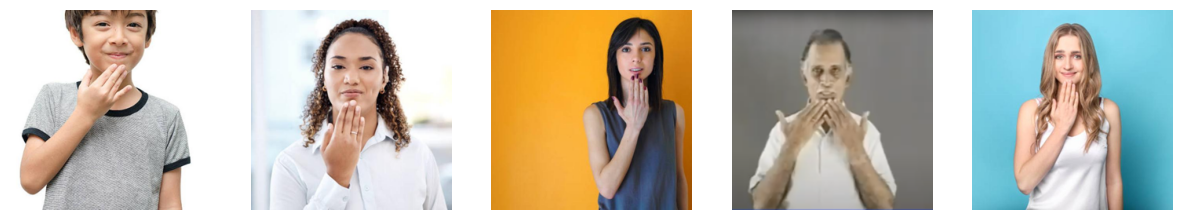

In [8]:
#@title Resize class images to 512x512 for diffusion model
folder_path = '/content/unzipped_ThankYou_files/ThankYou' #@param {type:"string"}

if len(os.listdir(folder_path)):
  resize_and_crop_images(folder_path)
  show_images_in_one_row(folder_path)

In [9]:
#@title Create an output folder for saving the results and checkpoints

if os.path.exists("/content/outputs"):
    print("Removing existing outputs folder")
    !rm -rf /content/outputs

print("Creating new outputs folder")
!mkdir /content/outputs

print('Output folder is created: /content/outputs')

Creating new outputs folder
Output folder is created: /content/outputs


In [13]:
import os

# Directory where your 5 images are currently stored
original_images_dir = '/content/unzipped_ThankYou_files'

# Define paths for instance and class directories
instance_data_dir = '/content/custom_dataset/instance_images'
class_data_dir = '/content/custom_dataset/class_images'

# Create instance and class directories
os.makedirs(instance_data_dir, exist_ok=True)
os.makedirs(class_data_dir, exist_ok=True)


In [14]:
import shutil

# Copy images to instance directory
for file_name in os.listdir(original_images_dir):
    full_file_name = os.path.join(original_images_dir, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, instance_data_dir)


In [15]:
# Copy images to class directory
for file_name in os.listdir(original_images_dir):
    full_file_name = os.path.join(original_images_dir, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, class_data_dir)


In [16]:
%cd /content/diffusers/examples/dreambooth

!python train_dreambooth.py --pretrained_model_name_or_path 'CompVis/stable-diffusion-v1-4' \
                            --revision "fp16" \
                            --instance_data_dir '/content/custom_dataset/instance_images' \
                            --class_data_dir '/content/custom_dataset/class_images' \
                            --instance_prompt 'hand sign language for Thank You' \
                            --class_prompt 'hand sign language for Thank You' \
                            --with_prior_preservation \
                            --prior_loss_weight 1.0 \
                            --num_class_images 10 \
                            --output_dir '/content/outputs' \
                            --resolution 512 \
                            --train_text_encoder \
                            --train_batch_size 2 \
                            --sample_batch_size 2 \
                            --max_train_steps 400 \
                            --checkpointing_steps 200 \
                            --gradient_accumulation_steps 1 \
                            --gradient_checkpointing \
                            --learning_rate 1e-6 \
                            --lr_scheduler 'constant' \
                            --lr_warmup_steps=0 \
                            --use_8bit_adam \
                            --validation_prompt 'hand sign language for Thank You' \
                            --num_validation_images 4 \
                            --mixed_precision="fp16" \
                            --enable_xformers_memory_efficient_attention \
                            --set_grads_to_none \
                            # --report_to 'wandb'

/content/diffusers/examples/dreambooth
/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
2024-06-05 17:00:12.278707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 17:00:12.278767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 17:00:12.376546: E external/local_xla/xla/s

In [17]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [18]:
from huggingface_hub import notebook_login
notebook_login()

In [28]:
from diffusers import DiffusionPipeline, UNet2DConditionModel, StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
import os

# Ensure the output directory exists
output_dir = '/content/outputs'
os.makedirs(output_dir, exist_ok=True)

# Load the text encoder from the Hugging Face Hub
text_encoder = CLIPTextModel.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder='text_encoder', use_auth_token=True)

# Save the text encoder model along with its configuration
text_encoder_output_dir = os.path.join(output_dir, 'text_encoder')
os.makedirs(text_encoder_output_dir, exist_ok=True)
text_encoder.save_pretrained(text_encoder_output_dir, save_config=True)

# Create the diffusion pipeline using the pre-trained model
pipeline = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:3027: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2417: UserWarning: `save_config` is deprecated and will be removed in v5 of Transformers. Use `is_main_process` instead.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
#@title Demo with Gradio UI for Inference
#@markdown The demo can be opened also in **other tab** on your browser or from another **computer** with given public url.
#@markdown - **Prompt:** Prompt for generation
#@markdown - **Negative Prompt:** Prevent generation from that prompt
#@markdown - **Samples:** Number of images that will be generated
#@markdown - **Guidance Scale:** It can be said as a coefficient for tune the power of the prompt on the generated images.
#@markdown - **Inference Steps:** How many iteration steps while denoising? If the generated images are noisy, try to increase this parameter.
#@markdown - **Height and Width:** Highly recommended 512
#@markdown - **RUN!**

import gradio as gr

def inference(prompt, num_samples, negative_prompt, guidance_scale, num_inference_steps, height, width):
    all_images = []
    images = pipeline(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale
    ).images
    all_images.extend(images)
    return all_images

with gr.Blocks() as demo:
    gr.HTML("<h2 style=\"font-size: 2em; font-weight: bold\" align=\"center\">Stable Diffusion Dreambooth - Run Concept</h2>")
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="Prompt")
            negative_prompt = gr.Textbox(label="Negative Prompt")
            samples = gr.Slider(label="Samples", value=1, maximum=12)
            guidance_scale = gr.Slider(label="Guidance Scale", value=7.5, maximum=30)
            num_inference_steps = gr.Slider(label="Inference Steps", value=50, maximum=500)
            height = gr.Slider(label="Height", value=512)
            width = gr.Slider(label="Width", value=512)
            run = gr.Button(value="Run")
        with gr.Column():
            gallery = gr.Gallery(show_label=False)

    run.click(inference, inputs=[prompt, samples, negative_prompt, guidance_scale, num_inference_steps, height, width], outputs=gallery)
    gr.Examples([["a photo of sks dog riding a bicycle", 1, "", 7.5, 150, 512, 512]], [prompt, samples, negative_prompt, guidance_scale, num_inference_steps, height, width], gallery, inference, cache_examples=False)

demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://7d3da8c557c878ff52.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


  0%|          | 0/50 [00:00<?, ?it/s]